# Hypothesis Formulation and Testing

To address my research questions, I will test the following hypotheses:

In [1]:
# import modules
## calculation modules
import numpy as np
import pickle
import scipy.stats
import pandas as pd
import scipy.special
import scipy.stats as stats
from scipy.stats import multivariate_normal
from hypothesis_test_functions import generate_samples, two_sample_one_sided_t_test, dagostino_pearson_test, generate_rmsle_samples, get_dists_and_data

In [2]:
# initialisation (indexing for model retrieval)
num_reps = 100
config_ids = [36,37,38,39] # configuration ids of the optimal hyperparameter models
replication_ids = {}
failed_experiment_IDs = []

for index, config_id in enumerate(config_ids):
    experimentIDs = np.arange(index*num_reps+1,(index+1)*num_reps+1) # corresponding experiment IDs 
    # removing experiments that didn't run successfully
    experimentIDs = np.delete(experimentIDs,failed_experiment_IDs)
    replication_ids[config_id] = experimentIDs

## Impact of SST Gradient on Surface Current Prediction using MVN NGBoost

### Prediction Performance

#### 1. Including SST gradient in the MVN NGBoost model improves model prediction performance:

##### RMSE

Let the random variable, $X$, be the Root Mean Square Error (RMSE) of the MVN NGBoost model evaluated on a test dataset

$$\begin{equation}
X = \sqrt{\frac{1}{2P} \sum_{i=1}^2\sum_{j=1}^P \left(\mathbf{u}_i^{(j)} - \hat{\mathbf{u}}_i^{(j)}\right)^2},\tag{1}
\end{equation}$$

where $P$ is the number of samples in the test data, $\mathbf{u}=(u,v)$, is the actual drifter velocity, and, $\hat{\mathbf{u}} = (\hat{u},\hat{v})$, is the expected value of the predicted distribution of the drifter velocity.

Let $X_{\nabla SST}$ be the RMSE on the test data for the MVN NGBoost model that uses Sea Surface Temperature (SST) gradients and let $X_0$ be the RMSE on the test data for the MVN NGBoost model that does not. 

In [3]:
def rmse(vec1,vec2):
    return 100*np.sqrt(np.mean(np.square(vec1-vec2))) # m/s -> cm/s

##### MAE
Let the random variable, $X$, be the Mean Absolute Error (MAE) of the MVN NGBoost model evaluated on a test dataset

$$X = \frac{1}{2P} \sum_{i=1}^2\sum_{j=1}^P \left\vert\mathbf{u}_i^{(j)} - \hat{\mathbf{u}}_i^{(j)}\right\vert,\tag{2}$$

where $P$ is the number of samples in the test data, $\mathbf{u}=(u,v)$, is the actual drifter velocity, and, $\hat{\mathbf{u}} = (\hat{u},\hat{v})$, is the expected value of the predicted distribution of the drifter velocity.

Let $X_{\nabla SST}$ be the MAE on the test data for the MVN NGBoost model that uses Sea Surface Temperature (SST) gradients and let $X_0$ be the MAE on the test data for the MVN NGBoost model that does not. 

In [4]:
def mae(vec1,vec2):
    return 100*np.mean(np.abs(vec1-vec2)) # m/s -> cm/s

##### MAAO

Let the random variable, $X$, be the Mean Absolute Angle Offset (MAAO) of the MVN NGBoost model evaluated on a test dataset

$$X = \frac{1}{P}\sum_{i=1}^P \arccos \left(\frac{\mathbf{u}_i\cdot\hat{\mathbf{u}}_i}{|\mathbf{u}_i||\hat{\mathbf{u}}_i|}\right),\tag{3}$$

where $P$ is the number of samples in the test data, $\mathbf{u}=(u,v)$, is the actual drifter velocity, and, $\hat{\mathbf{u}} = (\hat{u},\hat{v})$, is the expected value of the predicted distribution of the drifter velocity.

Let $X_{\nabla SST}$ be the MAAO on the test data for the MVN NGBoost model that uses Sea Surface Temperature (SST) gradients and let $X_0$ be the MAAO on the test data for the MVN NGBoost model that does not. 



In [5]:
def maao(vec1,vec2):
    elem_wise_dot_product = np.einsum('ij,ij->i',vec1,vec2)
    normalisation = np.linalg.norm(vec1,axis=1)*np.linalg.norm(vec2,axis=1)
    return np.mean(np.rad2deg(np.arccos(np.clip(
        elem_wise_dot_product/normalisation,
        -1,1
    ))))


##### MAPE

Let the random variable, $X$, be the Mean Absolute Percentage Error (MAPE) of the MVN NGBoost model evaluated on a test dataset

$$X = \frac{100}{2P} \sum_{i=1}^2\sum_{j=1}^P \left\vert\frac{\mathbf{u}_i^{(j)} - \hat{\mathbf{u}}_i^{(j)}}{\mathbf{u}_i^{(j)}}\right\vert, \tag{4}$$

where $P$ is the number of samples in the test data, $\mathbf{u}=(u,v)$, is the actual drifter velocity, and, $\hat{\mathbf{u}} = (\hat{u},\hat{v})$, is the expected value of the predicted distribution of the drifter velocity.

Let $X_{\nabla SST}$ be the MAPE on the test data for the MVN NGBoost model that uses Sea Surface Temperature (SST) gradients and let $X_0$ be the MAPE on the test data for the MVN NGBoost model that does not. 

In [6]:
def mape(true,pred):
    return 100*np.mean(np.abs((
        true-pred
    )/true))

##### RMSLE

Let the random variable, $X$, be the Root Mean Square Logarithmic Error (RMSLE) of the MVN NGBoost model evaluated on a test dataset

$$X = \sqrt{\frac{1}{2P} \sum_{i=1}^2\sum_{j=1}^P \left[\ln(1 +\mathbf{u}_i^{(j)}) - \ln(1+\hat{\mathbf{u}}_i^{(j)})\right]^2}, \tag{5}$$

where $P$ is the number of samples in the test data, $\mathbf{u}=(u,v)$, is the actual drifter velocity, and, $\hat{\mathbf{u}} = (\hat{u},\hat{v})$, is the expected value of the predicted distribution of the drifter velocity.

Let $X_{\nabla SST}$ be the RMSLE on the test data for the MVN NGBoost model that uses Sea Surface Temperature (SST) gradients and let $X_0$ be the RMSLE on the test data for the MVN NGBoost model that does not. 

In [7]:
def rmsle(vec1,vec2):
    return np.sqrt(np.mean(np.square(
        np.log(1+vec1)-np.log(1+vec2)
        )))

Obtain the samples $X_{\nabla SST}^{(1)}, \dots, X_{\nabla SST}^{(N)}$ and $X_{0}^{(1)}, \dots, X_{0}^{(N)}$  where $N=100$.

In [8]:
# load appropriate data and obtain samples

# initialisation
date = '2025-02-04'
early_stopping = 100
root_dir = r"C:\Users\vm2218\OneDrive - Imperial College London\PhD Project\seaducks\experiments\hpc_runs\04-02-2025\model_test_data"
root_dir_model = r"C:\Users\vm2218\OneDrive - Imperial College London\PhD Project\seaducks\experiments\hpc_runs\04-02-2025\fit_models"
file_name_prefix = "long_experiment_"
file_name_suffix = f"_date_{date}_early_stopping_{early_stopping}"

In [9]:
SST_grad_config_ID = 38
no_SST_grad_config_ID = 36
invalid_vals = []

##### Formulate One-Sided Two-Sample t-test
100 replications of MVN NGBoost fitting with different random seeds for each replication so that each replication is *independent*.

**Checking Normality: D'Agostino-Pearson test for normality**

Significance level: $\alpha = 0.05$

In [10]:
metrics = {'RMSE':rmse,'MAE':mae,'MAAO':maao,'MAPE':mape, 'RMSLE':rmsle} # error metric defining the random variable

print("=========== D'Agostino-Pearson Test for Normality ============")

for metric_name in metrics.keys():

    print(f'\n .*+ --------------- {metric_name} --------------- +*.')
    metric = metrics[metric_name]

    if metric_name == 'RMSLE':
        X_SST_grad, X_0 = generate_rmsle_samples(metric,SST_grad_config_ID,no_SST_grad_config_ID,
                                   num_reps, root_dir,file_name_prefix,replication_ids,file_name_suffix,invalid_vals=invalid_vals)
    else:
    # get samples
        X_SST_grad, X_0 = generate_samples(metric,SST_grad_config_ID,no_SST_grad_config_ID,
                                   num_reps, root_dir,file_name_prefix,replication_ids,file_name_suffix,invalid_vals=invalid_vals)
    X_1 = X_SST_grad
    X_2 = X_0
    X_1_name = 'with_STT_grad'
    X_2_name = 'no_SST_grad'

    # check samples are normally distributed
    dagostino_pearson_test(X_1,X_2,X_1_name,X_2_name)




=========== D'Agostino-Pearson Test for Normality ============

 .*+ --------------- RMSE --------------- +*.

For mu_X_1: mu_with_STT_grad, mu_X_2: mu_no_SST_grad 
.....................................................

X_1 follows a normal distribution.
p = 0.09

X_2 follows a normal distribution.
p = 0.08

 .*+ --------------- MAE --------------- +*.

For mu_X_1: mu_with_STT_grad, mu_X_2: mu_no_SST_grad 
.....................................................

X_1 follows a normal distribution.
p = 0.70

X_2 follows a normal distribution.
p = 0.70

 .*+ --------------- MAAO --------------- +*.

For mu_X_1: mu_with_STT_grad, mu_X_2: mu_no_SST_grad 
.....................................................

X_1 follows a normal distribution.
p = 0.24

X_2 follows a normal distribution.
p = 0.12

 .*+ --------------- MAPE --------------- +*.

For mu_X_1: mu_with_STT_grad, mu_X_2: mu_no_SST_grad 
.....................................................

X_1 does not follow a normal distribution.


Excluding MAPE from the t-tests (@Supervisors: Is there an alternative to this?)

One-sided two-sample $t$-test:

Let $\mu_{\nabla SST} = \frac{1}{N}\sum_{n=1}^N X_{\nabla SST}^{(n)}$, $\mu_0 = \frac{1}{N}\sum_{n=1}^N X_{0}^{(n)}$ be the sample means of $X_{\nabla SST}^{(1)}, \dots, X_{\nabla SST}^{(N)}$ and $X_{0}^{(1)}, \dots, X_{0}^{(N)}$  where $N=100$, respectively.

$H_0$: $\mu_{\nabla SST}$ < $\mu_0$.

$H_1$: $\mu_{\nabla SST} \geq \mu_0$.

Test statistic: $t = \frac{\mu_{\nabla SST} - \mu_{0}}{\sqrt{s^2_{\nabla SST}/N - s_0^2/N}}$ with $2(N-1)$ degrees of freedom.

=========== One-Sided Two-Sample t-Test ============

 .*+ --------------- RMSE --------------- +*.

For mu_X_1: mu_with_STT_grad, mu_X_2: mu_no_SST_grad 
.....................................................
Fail to Reject H0: mu_X_1 < mu_X_2
p = 1.00

mu_X_1 = 14.54
mu_X_2 = 14.78


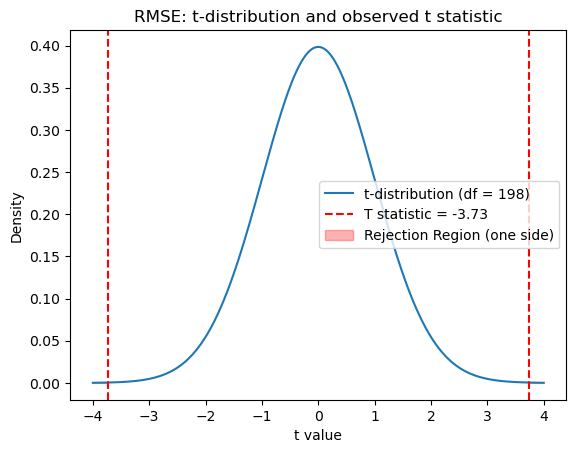


 .*+ --------------- MAE --------------- +*.

For mu_X_1: mu_with_STT_grad, mu_X_2: mu_no_SST_grad 
.....................................................
Fail to Reject H0: mu_X_1 < mu_X_2
p = 1.00

mu_X_1 = 9.84
mu_X_2 = 9.96


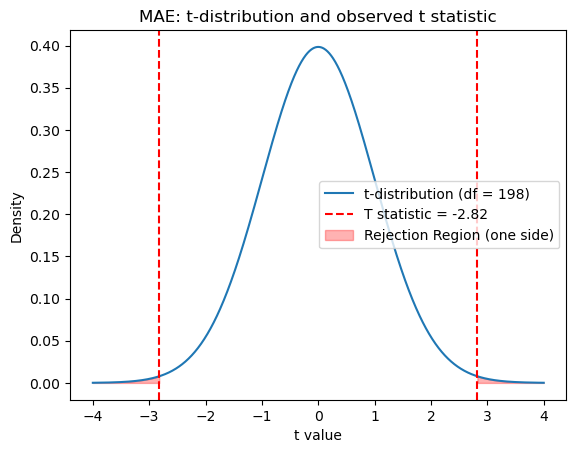


 .*+ --------------- MAAO --------------- +*.

For mu_X_1: mu_with_STT_grad, mu_X_2: mu_no_SST_grad 
.....................................................
Fail to Reject H0: mu_X_1 < mu_X_2
p = 1.00

mu_X_1 = 40.08
mu_X_2 = 40.49


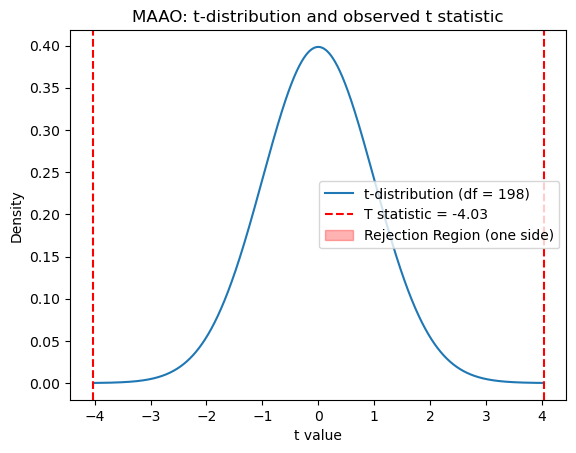


 .*+ --------------- RMSLE --------------- +*.

For mu_X_1: mu_with_STT_grad, mu_X_2: mu_no_SST_grad 
.....................................................
Fail to Reject H0: mu_X_1 < mu_X_2
p = 1.00

mu_X_1 = 0.22
mu_X_2 = 0.23


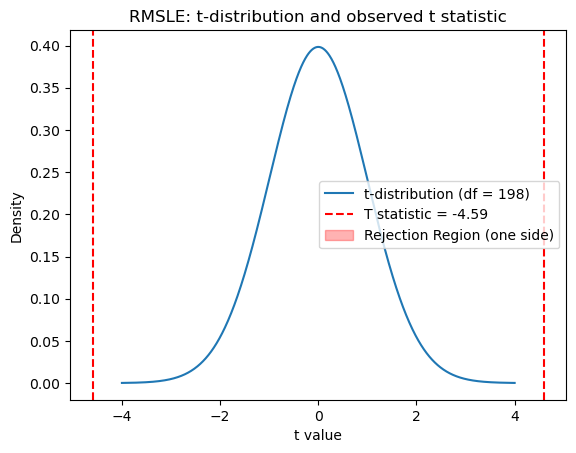

In [11]:
t_test_metrics = {'RMSE':rmse,'MAE':mae,'MAAO':maao,'RMSLE':rmsle} # error metric defining the random variable

print("=========== One-Sided Two-Sample t-Test ============")

for metric_name in t_test_metrics.keys():

    print(f'\n .*+ --------------- {metric_name} --------------- +*.')
    metric = t_test_metrics[metric_name]

    if metric_name == 'RMSLE':
        X_SST_grad, X_0 = generate_rmsle_samples(metric,SST_grad_config_ID,no_SST_grad_config_ID,
                                   num_reps, root_dir,file_name_prefix,replication_ids,file_name_suffix,invalid_vals=invalid_vals)
    else:
    # get samples
        X_SST_grad, X_0 = generate_samples(metric,SST_grad_config_ID,no_SST_grad_config_ID,
                                   num_reps, root_dir,file_name_prefix,replication_ids,file_name_suffix,invalid_vals=invalid_vals)
    X_1 = X_SST_grad
    X_2 = X_0
    X_1_name = 'with_STT_grad'
    X_2_name = 'no_SST_grad'

    two_sample_one_sided_t_test(X_1,X_2,num_reps,X_1_name,X_2_name,metric_name)

### Uncertainty Reduction

2. Including SST gradient in the MVN NGBoost model reduces the variance of:
- RMSE
- MAE
- MAAO
- MAPE
- RMSLE

To assess that, I will consider:
* Standard error
* Confidence interval width

In [12]:
t_test_metrics = {'RMSE':rmse,'MAE':mae,'MAAO':maao,'RMSLE':rmsle} # error metric defining the random variable

print("=========== Standard Error & Confidence Interval (Width) ============")

for metric_name in t_test_metrics.keys():

    print(f'\n .*+ --------------- {metric_name} --------------- +*.')
    metric = t_test_metrics[metric_name]

    if metric_name == 'RMSLE':
        X_SST_grad, X_0 = generate_rmsle_samples(metric,SST_grad_config_ID,no_SST_grad_config_ID,
                                   num_reps, root_dir,file_name_prefix,replication_ids,file_name_suffix,invalid_vals=invalid_vals)
    else:
    # get samples
        X_SST_grad, X_0 = generate_samples(metric,SST_grad_config_ID,no_SST_grad_config_ID,
                                   num_reps, root_dir,file_name_prefix,replication_ids,file_name_suffix,invalid_vals=invalid_vals)
    X_1 = X_SST_grad
    X_2 = X_0
    X_1_name = 'with_STT_grad'
    X_2_name = 'no_SST_grad'

    sem_1 = stats.sem(X_1)
    sem_2 = stats.sem(X_2)

    t_interval_1 = stats.t.interval(confidence=0.95, df=len(X_1)-1, 
              loc=np.mean(X_1), 
              scale=sem_1) 
    
    t_interval_2 = stats.t.interval(confidence=0.95, df=len(X_2)-1, 
              loc=np.mean(X_2), 
              scale=sem_2) 
    
    print_names = f"\nFor mu_X_1: mu_{X_1_name}, mu_X_2: mu_{X_2_name}"
    print(f"{print_names} \n{"."*len(print_names)}")

    print('\n===========Standard Error============')

    if np.isclose(sem_1,sem_2):
        print(f"\nstandard error of mu_{X_1_name} is approximately equal to standard error of mu_{X_2_name}")
    elif sem_1 > sem_2:
        print(f"\nstandard error of mu_{X_1_name} > standard error of mu_{X_2_name}")
    else:
        print(f"\nstandard error of mu_{X_1_name} < standard error of mu_{X_2_name}")
        
    print(f"\nStandard Error (mu_{X_1_name}): {sem_1:.5f}")
    print(f"Standard Error (mu_{X_2_name}): {sem_2:.5f}")

    print('\n============95 Percent Confidence Interval=============')
    
    width1 = t_interval_1[1]-t_interval_1[0]
    width2 = t_interval_2[1]-t_interval_2[0]

    if np.isclose(width1,width2):
        print(f"\n95 percent confidence interval of mu_{X_1_name} has approximately the same width as 95 percent confidence interval of mu_{X_2_name}")
    elif width1 > width2:
        print(f"\n95 percent confidence interval of mu_{X_1_name} is wider than 95 percent confidence interval of mu_{X_2_name}")
    else:
        print(f"\n95 percent confidence interval of mu_{X_1_name} is narrower than 95 percent confidence interval of mu_{X_2_name}")

    print(f"\n95 Percent Confidence Interval (mu_{X_1_name}): {t_interval_1}")
    print(f"width = {width1:.5f}")
    print(f"95 Percent Confidence Interval (mu_{X_2_name}): {t_interval_2}")
    print(f"width = {width2:.5f}")

=========== Standard Error & Confidence Interval (Width) ============

 .*+ --------------- RMSE --------------- +*.

For mu_X_1: mu_with_STT_grad, mu_X_2: mu_no_SST_grad 
.....................................................

===========Standard Error============

standard error of mu_with_STT_grad < standard error of mu_no_SST_grad

Standard Error (mu_with_STT_grad): 0.04547
Standard Error (mu_no_SST_grad): 0.04596

============95 Percent Confidence Interval=============

95 percent confidence interval of mu_with_STT_grad is narrower than 95 percent confidence interval of mu_no_SST_grad

95 Percent Confidence Interval (mu_with_STT_grad): (14.45235012410971, 14.632791115877463)
width = 0.18044
95 Percent Confidence Interval (mu_no_SST_grad): (14.692692877827723, 14.875095605183349)
width = 0.18240

 .*+ --------------- MAE --------------- +*.

For mu_X_1: mu_with_STT_grad, mu_X_2: mu_no_SST_grad 
.....................................................

===========Standard Error=========

Including SST gradient makes the 95% confidence intervals for RMSE and MAE smaller. The converse is true for MAAO and MAPE.

### Goodness of Fit
4. Including SST gradient in MVN NGBoost improves fit of the model to the data in:
- NLL
- $\chi^2$
- Prediction region coverage

In [13]:
# this is code from MV_Prediction - adapt as necessary

def NLL(dists, y):
    N = y.shape[0]
    nlls = [-dists[i].logpdf(y[i, :]) for i in range(N)]
    return nlls

def in_ci(error, sigma, alpha=0.95):
    crit_val = scipy.stats.chi2.ppf(alpha, sigma.shape[0])
    sigma_inv = np.linalg.inv(sigma)
    n = error.T @ sigma_inv @ error
    return n < crit_val

def coverage(dists, y, alpha=0.90):
    N = y.shape[0]
    covs = [dists[i].cov for i in range(N)]
    diffs = [y[i, :] - dists[i].mean for i in range(N)]
    ret = [in_ci(diff, cov, alpha=alpha) for diff, cov in zip(diffs, covs)]
    return ret

def matrix_area(mat, mult):
    p = mat.shape[0]
    return (
        2
        * (np.pi ** (p / 2))
        / scipy.special.gamma(p / 2)
        / p
        * (np.linalg.det(mat) ** 0.5)
        * mult ** (p / 2)
    )

def area(dists, y, alpha: float = 0.90):
    N = y.shape[0]
    covs = [dists[i].cov for i in range(N)]
    # TODO: Check this is correct for the area
    area = [matrix_area(cov, scipy.stats.chi2.ppf(alpha, cov.shape[1])) for cov in covs] #check that putting chi2 here was the correct thing to do
    return area * 100**2 # convert to cm^2/s

In [16]:
dists1, y1, dists2, y2 = get_dists_and_data(SST_grad_config_ID,no_SST_grad_config_ID,
                                   num_reps, root_dir,root_dir_model,file_name_prefix,replication_ids,file_name_suffix,invalid_vals=invalid_vals)

In [17]:
scipy_dists1 = [multivariate_normal(mean=dists1[0][0][ii],cov=dists1[0][1][ii]) for ii in range(dists1[0][0].shape[0])]
scipy_dists2 = [multivariate_normal(mean=dists2[0][0][ii],cov=dists2[0][1][ii]) for ii in range(dists2[0][0].shape[0])]

In [18]:
np.mean(NLL(scipy_dists1,y2))

AttributeError: 'list' object has no attribute 'shape'

In [22]:
np.mean(area(scipy_dists1,y1[0]))*100**2 # convert to cm^2/s
stats.sem(area(scipy_dists1,y1[0]))*100**2

11.343603786686806

##### Mean Error Metric Visualisations

In [15]:
# load data
path_to_data = r'C:\Users\vm2218\OneDrive - Imperial College London\PhD Project\seaducks\data\complete_filtered_nao_drifter_dataset.h5'
full_data = pd.read_hdf(path_to_data)

# separate into explanatory and response variables
explanatory_var_labels = ['u_av','v_av','lat','lon','day_of_year','Wx','Wy','Tx','Ty','sst_x_derivative','sst_y_derivative']
polar_explanatory_var_labels = ['R_vel_av','arg_vel_av','lat','lon','day_of_year','R_wind_speed','arg_wind_speed','R_wind_stress','arg_wind_stress','sst_x_derivative','sst_y_derivative']
response_var_labels = ['u','v']

In [ ]:
bin_size = 0.2
lat_grid = np.arange(-90,90 + bin_size,bin_size)
lon_grid = np.arange(-180,180 + bin_size,bin_size)
root_dir = r"C:\Users\vm2218\OneDrive - Imperial College London\PhD Project\seaducks\experiments\hpc_runs\04-02-2025\fit_models"

for ii in range(1):
    #load models (with SST gradient)
    with open(fr'{root_dir}/{file_name_prefix}{replication_ids[SST_grad_config_ID][ii]}{file_name_suffix}.p', 'rb') as pickle_file:
        model_sst_grad = pickle.load(pickle_file)
    print('MVN NGBoost with SST gradient loaded successfully')
    pred_dists_sst = model_sst_grad.scipy_distribution(full_data[explanatory_var_labels],cmat_output = True)
    print('model evaluated on full dataset')
    full_locs_sst, full_covs_sst = pred_dists_sst
    full_data.loc[:,'mvn_ngb_prediction_u_sst'] = full_locs_sst[:,0]
    full_data.loc[:,'mvn_ngb_prediction_v_sst'] = full_locs_sst[:,1]
    print('full dataset updated with prediction')

    # load models (without SST gradient)
    with open(fr'{root_dir}/{file_name_prefix}{replication_ids[no_SST_grad_config_ID][ii]}{file_name_suffix}.p', 'rb') as pickle_file:
        model_no_sst_grad = pickle.load(pickle_file)
    print('MVN NGBoost with out SST gradient loaded successfully')
    pred_dists_no_sst = model_no_sst_grad.scipy_distribution(full_data[explanatory_var_labels],cmat_output = True)
    print('model evaluated on full dataset')
    full_locs_no_sst, full_covs_no_sst = pred_dists_no_sst
    full_data.loc[:,'mvn_ngb_prediction_u_no_sst'] = full_locs_no_sst[:,0]
    full_data.loc[:,'mvn_ngb_prediction_v_no_sst'] = full_locs_no_sst[:,1]
    print('full dataset updated with prediction')

print('calculating plotting frame')
errs = err_df(full_data,lat_grid,lon_grid,bin_size)
 

ModuleNotFoundError: No module named 'seaducks'

In [26]:
errs.loc[:,'maao_sst'] = errs['maao_sst'].apply(lambda x :np.rad2deg(np.mean(x)))  

C:\Users\vm2218\AppData\Local\Temp\ipykernel_2180\3486083371.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  errs.loc[:,'maao_sst'] = errs['maao_sst'].apply(lambda x :np.rad2deg(np.mean(x)))


In [27]:
errs.loc[:,'maao_no_sst'] = errs['maao_no_sst'].apply(lambda x :np.rad2deg(np.mean(x)))  

C:\Users\vm2218\AppData\Local\Temp\ipykernel_2180\979570135.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  errs.loc[:,'maao_no_sst'] = errs['maao_no_sst'].apply(lambda x :np.rad2deg(np.mean(x)))


fig successful
rmse_sst plot successful
rmse_no_sst plot successful
mae_sst plot successful
mae_no_sst plot successful
maao_sst plot successful
maao_no_sst plot successful
rmsle_sst plot successful
rmsle_no_sst plot successful
letters added


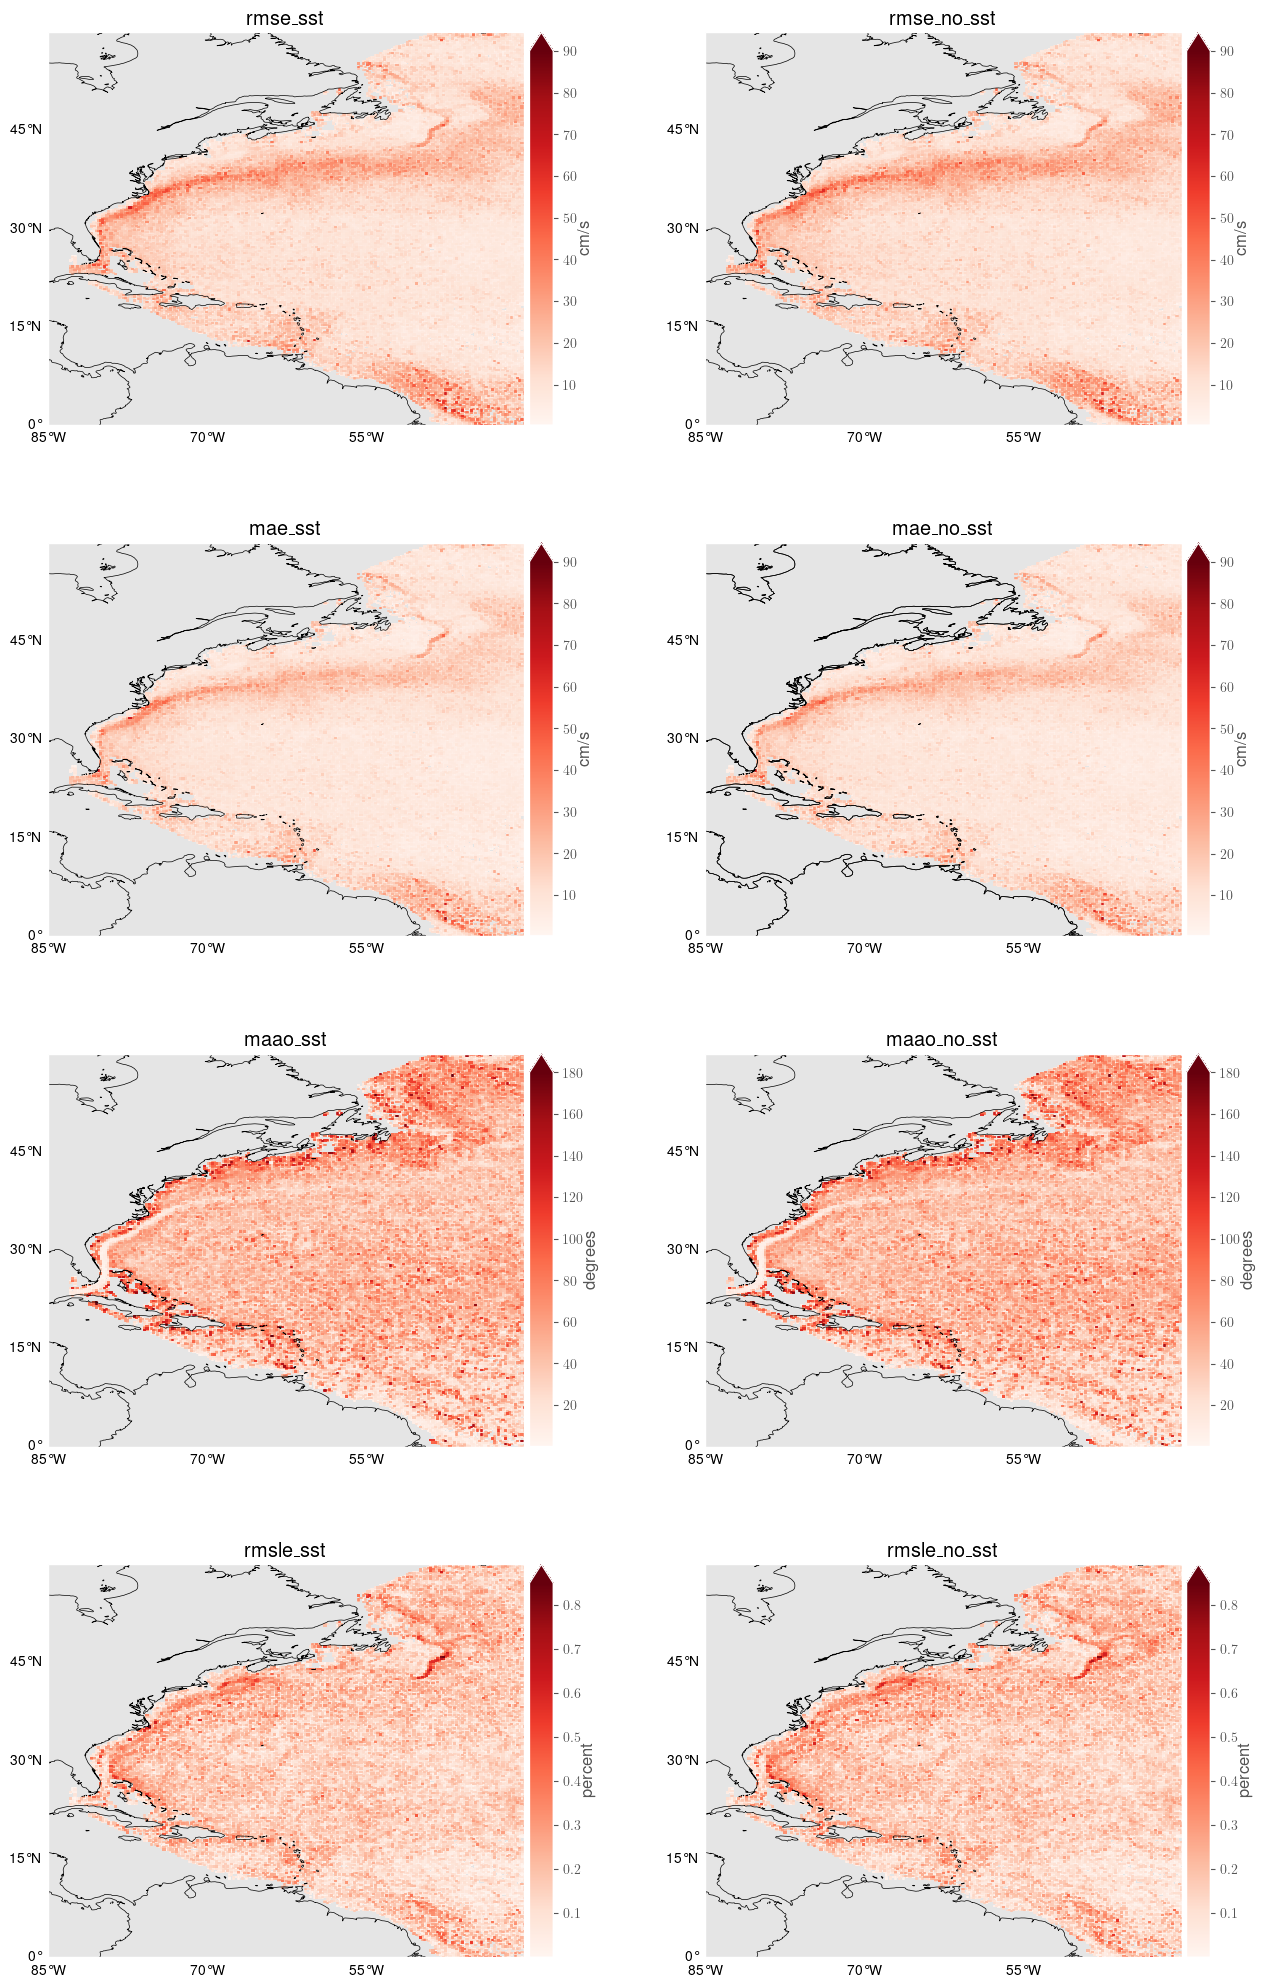

In [29]:
fig, axs = plt.subplots(4,2,figsize=(15,25), subplot_kw= {"projection":ccrs.PlateCarree()})
metric_names = ['rmse_sst', 'rmse_no_sst','mae_sst', 'mae_no_sst','maao_sst','maao_no_sst','rmsle_sst','rmsle_no_sst']
titles = metric_names
cbar_names = [r"cm/s", r"cm/s",r"cm/s",r"cm/s", r"degrees", r"degrees", "percent", "percent", "", "" ]
extent = [-85.01,#summaries['lon'].min(),
          full_data['lon'].max(),
          -0.01,
          full_data['lat'].max()
         ]

print('fig successful')
for ii, metric in enumerate(metric_names):
    col = int(ii%2)
    row = int((ii-col)/2)
    current_ax = axs[row,col]
    if metric == 'rmse_sst' or metric == 'rmse_no_sst':
        vmax_manual = 90
    elif metric == 'maao_sst' or metric == 'maao_no_sst':
        vmax_manual = 180
    elif metric == 'mape_sst' or metric == 'mape_no_sst':
        vmax_manual = 500
    elif metric == 'rmsle_sst' or metric == 'rmsle_no_sst':
        vmax_manual = 0.85
    cax = plot_column(errs,
                      metric,
                      ax=current_ax,
                      cmap='Reds',vmax_manual=vmax_manual)
    print(f'{metric} plot successful')
    current_ax.set_title(titles[ii])
    current_ax.set_extent(extent,ccrs.PlateCarree())
    current_ax.coastlines()
    current_ax.set_aspect('auto')
    add_gridlines(current_ax)
    cax.set_ylabel(cbar_names[ii], labelpad=0.1)
    
add_letters(axs)
print('letters added')
plt.subplots_adjust(wspace=0.3, hspace=0.3)
axs[1,1].coastlines()
axs[1,1].set_aspect('auto')

plt.show()

3. Including SST Gradient in the MVN NGBoost model reduces the area of the prediction region.

### SST Gradient as Physical Phenomena

5. SST gradients are significant features for explaining the variance of the MVN NGBoost parameters.

6. SST gradients improve prediction significantly in the Gulf Stream and Labrador Current regions.


### Polar Form

Including the velocities in polar form does all the above things

## The SeaDucks Implementation

7. The SeaDucks implementation of MVN NGBoost improves upon the model presented by O'Malley et al. (2023) on the mean of:
- RMSE
- NLL
- Prediction Region Area
- Prediction Region Coverage

8. The SeaDucks implementation of MVN NGBoost improves upon the model presented by O'Malley et al. (2023) on the variance of:
- RMSE
- NLL
- Prediction Region Area
- Prediction Region Coverage


## Observations about the MVN NGBoost Model

9. Increasing the number of training points increases the model's reliance on (lat, lon, time) and decreases the reliance on physical features.

10. There is seasonal variation in the performance of MVN NGBoost.


11. The model residuals are normally distributed
- linear
- angular

In [ ]:
# check samples are normally distributed
alpha = 0.05

metric_names = []

for ii in range(len(metric_names)):
    _, p_sst = scipy.stats.normaltest(np.array(errs[[metric_names[2*ii]]]))
    print(np.array(errs[[metric_names[2*ii]]]))
    _, p_0 = scipy.stats.normaltest(np.array(errs[[metric_names[2*ii+1]]]))

    test_pairs = [['X_SST_grad',p_sst],['X_0',p_0]]
    for jj,pair in enumerate(test_pairs):
        if pair[1] < alpha:
            print(f"\n{pair[0]} does not follow a normal distribution for {metric_names[2*ii+jj]}.")
            print(f"p = {pair[1]}")
        else:
            print(f"\n{pair[0]} follows a normal distribution {metric_names[2*ii+jj]}.")
            print(f"p = {pair[1]}")

12. There are clusters of regions that perform poorly in the following metrics:
- RMSE
- MAE
- MAAO
- MAPE

## Mean Absolute Angle Offset

13. MAAO gives us more information about improvements in direction prediction than RMSE.